# 인물 모드 문제점 찾기

In [2]:
# 필요한 모듈 import 및 버전확인
import os
from importlib.metadata import version
import cv2
import pixellib
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


## Step 1. 인물모드 만들어보기
### 1. 배경을 blur하는 인물모드 사진

(240, 320, 3)


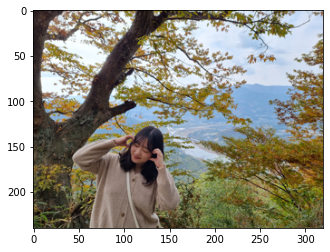

In [3]:
# 이미지 가져오기
img_path_basic = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_sy_2.png'
img_orig_basic = cv2.imread(img_path_basic)

print(img_orig_basic.shape)

plt.imshow(cv2.cvtColor(img_orig_basic, cv2.COLOR_BGR2RGB))
# OpenCV는 BGR형식으로 되어있기 때문에 RGB형식으로 변경
plt.show()

In [4]:
# PixelLib에서 제공해 주는 모델 다운로드
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
# os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
# PixelLib가 제공하는 모델의 url

# 다운로드를 시작
urllib.request.urlretrieve(model_url, model_file)
# request 모듈의 urlretrieve 함수 : model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f9eccd625e0>)

In [5]:
# 다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수

In [6]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path_basic)
# segmentAsPascalvoc()함수 : 입력된 이미지를 분할, 분할 출력의 배열을 가져옴(분할은 pacalvoc 데이터로 학습된 모델을 이용)

In [7]:
# pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 라벨은 0부터 시작한다. tv=20(class_id), person=15(class_id)

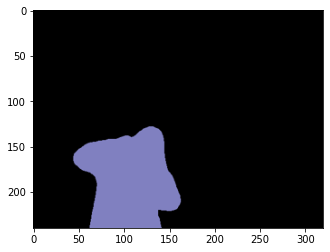

In [8]:
plt.imshow(output)
plt.show()

In [9]:
segvalues 
# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
# segvalues : class_ids와 masks가 있다.

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [11]:
# 컬러맵 만들기 (output에 어떤 색상으로 나타나 있는지)
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

In [13]:
# 색상순서 변경(colormap의 배열은 RGB 순, output의 배열은 BGR 순으로 채널 배치)
seg_color = (128,128,192)

(240, 320)


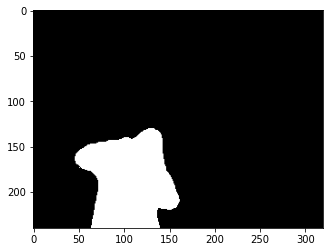

In [14]:
# seg_color로만 이루어진 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1)

print(seg_map.shape) 

plt.imshow(seg_map, cmap='gray')
 # seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
 # cmap 값을 변경하면 다른 색상으로 확인이 가능
plt.show()

- np.all : 배열의 모든 데이터가 조건과 맞으면 True 하나라도 다르면 False  
여기서는 output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)로 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 나온다.

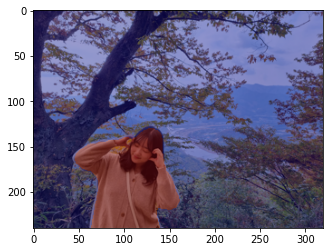

In [15]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show_basic = img_orig_basic.copy()

# True과 False인 값을 각각 255과 0으로 바꿔주기
img_mask_basic = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask_basic = cv2.applyColorMap(img_mask_basic, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show_basic = cv2.addWeighted(img_show_basic, 0.6, color_mask_basic, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_basic, cv2.COLOR_BGR2RGB))
plt.show()

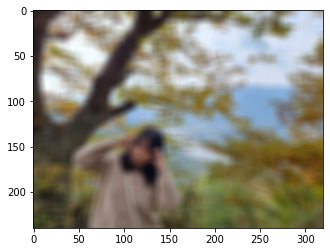

In [22]:
# 배경 흐리게 하기
img_orig_basic_blur = cv2.blur(img_orig_basic, (10,10))
 # (10,10)은 blurring kernel size로 변경 가능
    
plt.imshow(cv2.cvtColor(img_orig_basic_blur, cv2.COLOR_BGR2RGB))
plt.show()

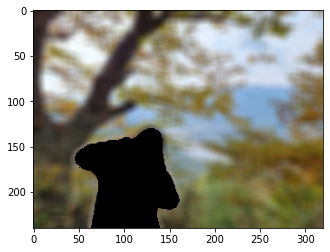

In [23]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출하기
img_mask_color_basic = cv2.cvtColor(img_mask_basic, cv2.COLOR_GRAY2BGR)

img_bg_mask_basic = cv2.bitwise_not(img_mask_color_basic)

img_bg_blur_basic = cv2.bitwise_and(img_orig_basic_blur, img_bg_mask_basic)
plt.imshow(cv2.cvtColor(img_bg_blur_basic, cv2.COLOR_BGR2RGB))
plt.show()

- cv2.bitwise_not(): 이미지가 반전(마스크에서 배경이 0, 사람이 255 -> 배경이 255, 사람이 0)  
- cv2.bitwise_and(): 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다. (0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문) -> 사람은 사라지고 배경만 남는다.

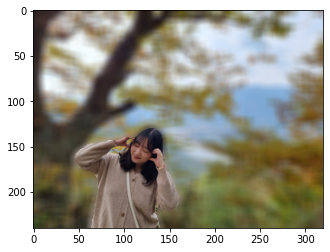

In [24]:
# 흐린 배경과 원본 영상 합성
img_concat_basic = np.where(img_mask_color_basic==255, img_orig_basic, img_bg_blur_basic)
plt.imshow(cv2.cvtColor(img_concat_basic, cv2.COLOR_BGR2RGB))
plt.show()

- np.where(조건, 참일 때, 거짓일 때)

### 2. 크로마키 배경 합성한 인물모드 사진

(240, 320, 3)
(240, 320, 3)


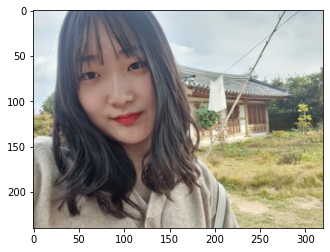

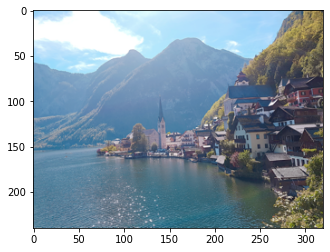

In [25]:
# 인물 이미지와 배경 이미지가져오기
img_path_ps = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_sy.png'
img_orig_ps = cv2.imread(img_path_ps)


img_path_bg = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_bg.png'
img_orig_bg = cv2.imread(img_path_bg)

print(img_orig_ps.shape)
print(img_orig_bg.shape)

plt.imshow(cv2.cvtColor(img_orig_ps, cv2.COLOR_BGR2RGB)) # OpenCV는 BGR형식으로 되어있기 때문에 RGB형식으로 변경
plt.show()

plt.imshow(cv2.cvtColor(img_orig_bg, cv2.COLOR_BGR2RGB))
plt.show()

- PixelLib에서 제공해 주는 모델 다운로드 및 다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델을 생성, pascalvoc 데이터의 라벨종류 설정은 위에서 진행했으므로 생략하도록 하겠다.

In [26]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path_ps)

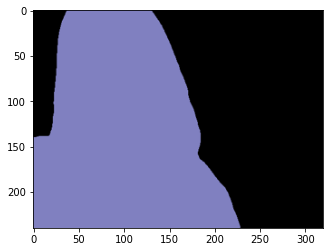

In [27]:
plt.imshow(output)
plt.show()

In [28]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [29]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [31]:
# 컬러맵 만들기 (output에 어떤 색상으로 나타나 있는지)
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [32]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

In [35]:
# 색상순서 변경(colormap의 배열은 RGB 순, output의 배열은 BGR 순으로 채널 배치)
seg_color_ps = (128,128,192)

(240, 320)


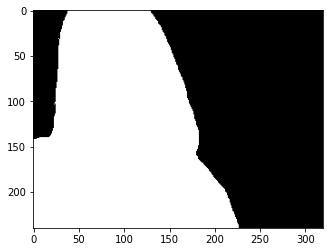

In [36]:
# seg_color_ps로만 이루어진 마스크 만들기
seg_map_ps = np.all(output==seg_color_ps, axis=-1)

print(seg_map_ps.shape) 

plt.imshow(seg_map_ps, cmap='gray')
 # seg_color_ps 값이 person을 값이므로 사람이 있는 위치를 제외하고는 gray로 출력
 # cmap 값을 변경하면 다른 색상으로 확인이 가능
plt.show()

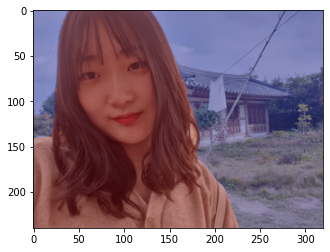

In [37]:
# 원본이미지를 img_show_ps에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask_ps를 만든뒤 두 이미지를 합쳐서 출력
img_show_ps = img_orig_ps.copy()

# True과 False인 값을 각각 255과 0으로 바꿔주기
img_mask_ps = seg_map_ps.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask_ps = cv2.applyColorMap(img_mask_ps, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show_ps = cv2.addWeighted(img_show_ps, 0.6, color_mask_ps, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_ps, cv2.COLOR_BGR2RGB))
plt.show()

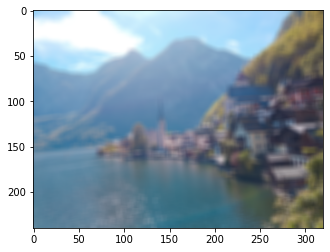

In [46]:
# 배경이미지 흐리게 만들기
img_orig_bg_blur = cv2.blur(img_orig_bg, (7,7))
 # (7,7)은 blurring kernel size로 변경 가능
    
plt.imshow(cv2.cvtColor(img_orig_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

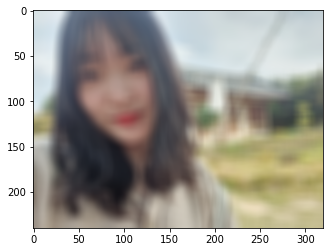

In [40]:
# 인물이미지 흐리게 만들기
img_orig_ps_blur = cv2.blur(img_orig_ps, (13,13))
 # (13,13)은 blurring kernel size로 변경 가능
    
plt.imshow(cv2.cvtColor(img_orig_ps_blur, cv2.COLOR_BGR2RGB))
plt.show()

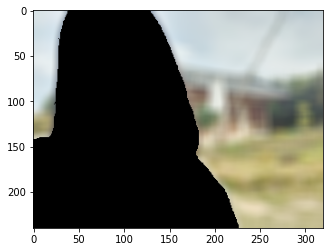

In [42]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출하기
img_mask_color_ps = cv2.cvtColor(img_mask_ps, cv2.COLOR_GRAY2BGR)

img_bg_mask_ps = cv2.bitwise_not(img_mask_color_ps)

img_bg_blur_ps = cv2.bitwise_and(img_orig_ps_blur, img_bg_mask_ps)
plt.imshow(cv2.cvtColor(img_bg_blur_ps, cv2.COLOR_BGR2RGB))
plt.show()
# cv2.bitwise_not(): 이미지가 반전(마스크에서 배경이 0, 사람이 255 -> 배경이 255, 사람이 0)
# cv2.bitwise_and(): 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다. (0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문)
# -> 사람은 사라지고 배경만 남는다.

- 인물에 다른 배경을 합성할 때에는 bitwise_not과 bitwise_and 과정을 따로 거치지 않아도 된다.

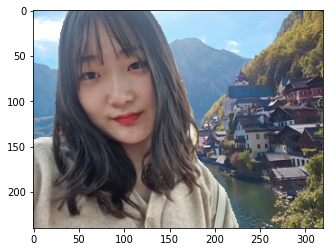

In [47]:
# blur처리 하지 않은 크로마키 배경 합경
img_concat = np.where(img_mask_color_ps==255, img_orig_ps, img_orig_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

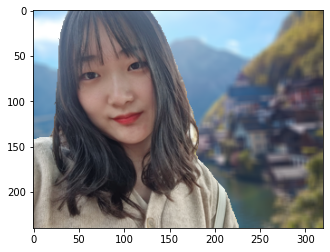

In [45]:
# blur처리 한 크로마키 배경 합경
img_concat = np.where(img_mask_color_ps==255, img_orig_ps, img_orig_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 처음에 흐리게 만든 배경이미지를 RGB로 바꾼 것을 np.where에 넣어주어 에러가 발생했다. 바로 다음 줄인 plt.imshow에서 BGR을 RGB로 바꿔주는 작업을 했는데 그걸 간과하고 RGB로 바꾼 값을 넣어주었다. 지금까지 항상 앞부분에서 스펠링을 잘못써서 실수가 발생했는데 오늘 실수를 통해 코드는 앞뒤로 유기적으로 연결되어있고, 그걸 간과하지 말아야겠다는 생각이 들었다.

### 3. 동물사진으로 아웃포커싱 사진 만들기 + 배경 합성

(320, 284, 3)
(320, 240, 3)


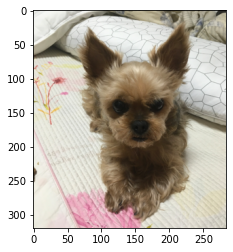

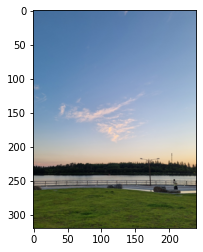

In [3]:
# 동물이미지와 배경이미지 가져오기
img_path_momo = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_momo.png'
img_orig_momo = cv2.imread(img_path_momo)

img_path_bg2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_bg_2.png'
img_orig_bg2 = cv2.imread(img_path_bg2)

print(img_orig_momo.shape)
print(img_orig_bg2.shape)

plt.imshow(cv2.cvtColor(img_orig_momo, cv2.COLOR_BGR2RGB))
# OpenCV는 BGR형식으로 되어있기 때문에 RGB형식으로 변경
plt.show()

plt.imshow(cv2.cvtColor(img_orig_bg2, cv2.COLOR_BGR2RGB))
plt.show()

(320, 240, 3)


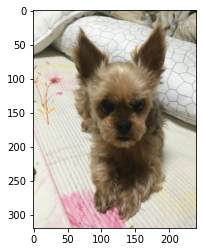

In [51]:
# 동물이미지 사이즈 조절
img_orig_momo_re = cv2.resize(img_orig_momo, dsize=(240, 320), interpolation=cv2.INTER_AREA)
cv2.imwrite('images/image_momo_re.png', img_orig_momo_re)

print(img_orig_momo_re.shape)

plt.imshow(cv2.cvtColor(img_orig_momo_re, cv2.COLOR_BGR2RGB))
plt.show()

(320, 240, 3)


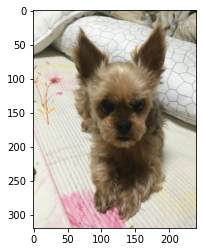

In [52]:
img_path_momo_re = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_momo_re.png'
img_orig_momo_re = cv2.imread(img_path_momo_re)

print(img_orig_momo_re.shape)

plt.imshow(cv2.cvtColor(img_orig_momo_re, cv2.COLOR_BGR2RGB))
plt.show()

- 위에서 배경 합성할 때에는 사진의 크기가 동일했는데 이번에는 합성할 두 사진의 크기가 다르다. 이런 경우에도 잘 합성이 될 지 궁금해졌다. 끝까지 해본 결과 크기가 안맞아서 합성이 안됐다. 결국 큰 사이즈 사진의 크기를 먼저 조정해서 크기를 맞춰준 후에 다시 합성을 했다. 크기를 조정해서 저장한 후에 그 사진을 꺼내는 것은 처음하는 것이었기 때문에 구글 검색의 도움을 많이 받았는데, 경로와 설정된 변수 이름 때문에 몇번 에러가 발생해 고생하긴 했지만 다행히 잘 해결할 수 있었다. 설정된 변수를 제대로 기억하고 파악하는 것이 정말 중요하다는 생각이 들었다.
- PixelLib에서 제공해 주는 모델 다운로드 및 다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델을 생성, pascalvoc 데이터의 라벨종류 설정은 위에서 진행했으므로 생략하도록 하겠다.

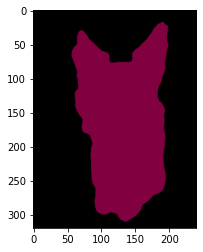

In [53]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path_momo_re)

plt.imshow(output)
plt.show()

In [54]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [55]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [56]:
# 컬러맵 만들기
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [57]:
# dog을 나타내는 12번째 색상
colormap[12]

array([ 64,   0, 128])

In [58]:
# 색상순서 변경
seg_color_momo = (128, 0, 64)

(320, 240)


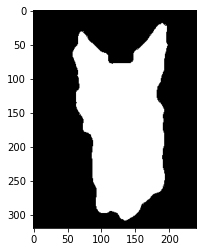

In [59]:
# seg_color_momo로만 이루어진 마스크 만들기
seg_map_momo = np.all(output==seg_color_momo, axis=-1)
 # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
 # 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열
print(seg_map_momo.shape) 
plt.imshow(seg_map_momo, cmap='gray')
 # seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
 # cmap 값을 변경하면 다른 색상으로 확인이 가능
plt.show()

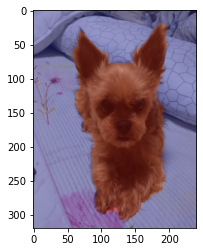

In [61]:
# 원본이미지를 img_show_momo에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask_momo를 만든뒤 두 이미지를 합쳐서 출력
img_show_momo = img_orig_momo_re.copy()

# True와 False인 값을 각각 255와 0으로 바꿔주기
img_mask_momo = seg_map_momo.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔보기
color_mask_momo = cv2.applyColorMap(img_mask_momo, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐보기
img_show_momo = cv2.addWeighted(img_show_momo, 0.6, color_mask_momo, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_momo, cv2.COLOR_BGR2RGB))
plt.show()

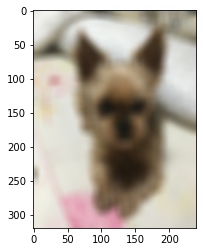

In [62]:
# 동물이미지 흐리게 하기
img_orig_momo_blur = cv2.blur(img_orig_momo_re, (15,15))

plt.imshow(cv2.cvtColor(img_orig_momo_blur, cv2.COLOR_BGR2RGB))
plt.show()

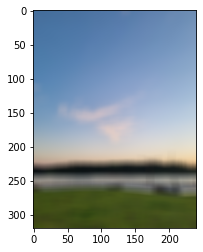

In [63]:
# 배경이미지 흐리게 하기
img_orig_bg2_blur = cv2.blur(img_orig_bg2, (13,13))

plt.imshow(cv2.cvtColor(img_orig_bg2_blur, cv2.COLOR_BGR2RGB))
plt.show()

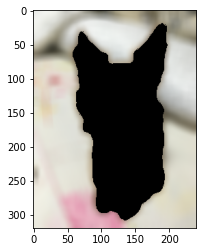

In [64]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출하기
img_mask_color_momo = cv2.cvtColor(img_mask_momo, cv2.COLOR_GRAY2BGR)

img_bg_mask_momo = cv2.bitwise_not(img_mask_color_momo)

img_bg_blur_momo = cv2.bitwise_and(img_orig_momo_blur, img_bg_mask_momo)
plt.imshow(cv2.cvtColor(img_bg_blur_momo, cv2.COLOR_BGR2RGB))
plt.show()

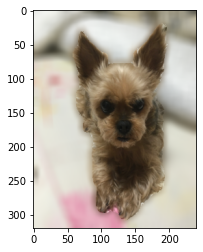

In [65]:
# 흐린 원래 배경과 원본 영상 합성
img_concat_momo = np.where(img_mask_color_momo==255, img_orig_momo_re, img_bg_blur_momo)
plt.imshow(cv2.cvtColor(img_concat_momo, cv2.COLOR_BGR2RGB))
plt.show()

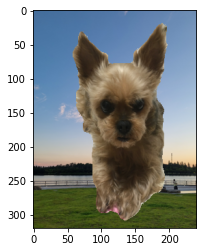

In [68]:
# 다른 배경과 동물이미지 합성
img_concat_momo2 = np.where(img_mask_color_momo==255, img_orig_momo_re, img_orig_bg2)
plt.imshow(cv2.cvtColor(img_concat_momo2, cv2.COLOR_BGR2RGB))
plt.show()

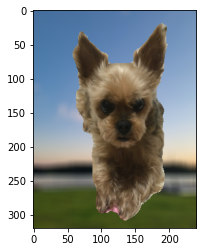

In [72]:
# blur된 다른 배경과 동물이미지 합성
img_concat_momo3 = np.where(img_mask_color_momo==255, img_orig_momo_re, img_orig_bg2_blur)
plt.imshow(cv2.cvtColor(img_concat_momo3, cv2.COLOR_BGR2RGB))
plt.show()

### 4. 사진 속 label을 모두 인식할 수 있을까?
- 지금까지 너무 깔끔한 사진들로만 진행한 거 같아서 인물도 2명이고 버스와 차 등 여러 label이 있을 때 모두 인식할 수 있을지 궁금해서 시도해보았다.

(213, 320, 3)


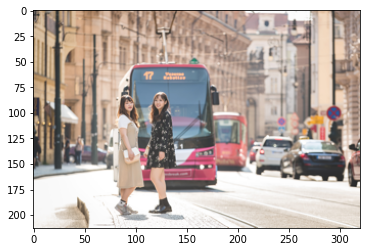

In [3]:
# 이미지 가져오기
img_path_eu = os.getenv('HOME')+'/aiffel/human_segmentation/images/image_eu.png'
img_orig_eu = cv2.imread(img_path_eu)

print(img_orig_eu.shape)

plt.imshow(cv2.cvtColor(img_orig_eu, cv2.COLOR_BGR2RGB))
# OpenCV는 BGR형식으로 되어있기 때문에 RGB형식으로 변경
plt.show()

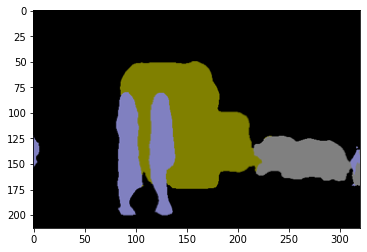

In [6]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path_eu)

plt.imshow(output)
plt.show()

- 사진 속에 있는 설정된 label은 거의 인식하는 것으로 보인다. 다만 복잡한 사진을 다루니까 문제가 더 생기는 듯 하다. 양 옆에 사람이 아닌데 사람이라고 표시되는 경우가 있다.  
- PixelLib에서 제공해 주는 모델 다운로드 및 다운로드한 모델을 이용해 PixelLib로 사용할 세그멘테이션 모델을 생성, - pascalvoc 데이터의 라벨종류 설정은 위에서 진행했으므로 생략하도록 하겠다.

In [11]:
segvalues

{'class_ids': array([ 0,  6,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [12]:
# segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bus
car
person


In [14]:
# 컬러맵 만들기 (output에 어떤 색상으로 나타나 있는지)
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
print(colormap[:20]) # 생성한 20개의 컬러맵 출력

# 버스을 나타내는 6번째 색상
print(colormap[6])

# 차를 나타내는 7번째 색상
print(colormap[7])

# 사람을 나타내는 15번째 색상
print(colormap[15])

[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]
[  0 128 128]
[128 128 128]
[192 128 128]


In [15]:
# 사람 색상순서 변경
seg_color_person = (128, 128, 192)

(213, 320)


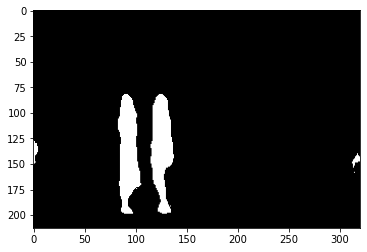

In [17]:
# seg_color_person으로만 이루어진 마스크 만들기
seg_map_eu = np.all(output==seg_color_person, axis=-1)
print(seg_map_eu.shape)

plt.imshow(seg_map_eu, cmap='gray')
plt.show()

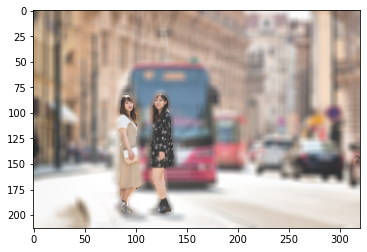

In [20]:
# 원본이미지를 img_show_eu에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask_eu를 만든뒤 두 이미지를 합쳐서 출력
img_show_eu = img_orig_eu.copy()

img_mask_eu = seg_map_eu.astype(np.uint8) * 255 # True과 False인 값을 각각 255과 0으로 바꿔주기

color_mask_eu = cv2.applyColorMap(img_mask_eu, cv2.COLORMAP_JET) # 255와 0을 적당한 색상으로 바꿔보기

img_show_eu = cv2.addWeighted(img_show_eu, 0.6, color_mask_eu, 0.4, 0.0) # 원본 이미지와 마스크를 적당히 합쳐보기

# 배경 흐리게 하기
img_orig_eu_blur = cv2.blur(img_orig_eu, (7,7))

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출하기
img_mask_color_eu = cv2.cvtColor(img_mask_eu, cv2.COLOR_GRAY2BGR)

img_bg_mask_eu = cv2.bitwise_not(img_mask_color_eu)

img_bg_blur_eu = cv2.bitwise_and(img_orig_eu_blur, img_bg_mask_eu)

# 흐린 배경과 원본 영상 합성하기
img_concat_eu = np.where(img_mask_color_eu==255, img_orig_eu, img_bg_blur_eu)
plt.imshow(cv2.cvtColor(img_concat_eu, cv2.COLOR_BGR2RGB))
plt.show()

-----

## Step 2. 사진에서 문제점 찾기

### LMS사진 문제점

![IMG_66A0D4D8890D-1](https://user-images.githubusercontent.com/116326867/205914676-8e4346b6-1952-4383-b8da-0a46829ff49a.jpeg)

- 이어폰의 경우 일부는 person으로 인식되고, 일부는 person으로 인식되지 않아 중간에 줄이 끊어졌다.  
- 뒷배경에 있는 옷이 person으로 인식되어 blur처리되지 않았다.  
- 어깨부분과 손목부분 옷이 person으로 인식되어야 하는데, 배경으로 인식되어 blur처리된 부분이 있다.

### 두번째 사진 문제점

![IMG_D0193BFCF994-1](https://user-images.githubusercontent.com/116326867/205914721-eae00bbd-9d8e-46e2-90f8-d432b1103c89.jpeg)

- 머리카락 사이로 보이는 배경은 person으로 묶여서 인식되어 다른 배경으로 바뀌지 않았다.

### 세번째 사진 문제점

![IMG_B4D9C250D736-1](https://user-images.githubusercontent.com/116326867/205914746-4b8d5e4b-8198-4f18-bef1-7087e522f243.jpeg)

- 강아지가 손을 모으고 있는 부분에서 컴퓨터가 인식하기에 비슷한 색이라고 느꼈는지 깔끔하게 구분되지 않았다.

### 네번째 사진 문제점

![IMG_511E9A5E6A23-1](https://user-images.githubusercontent.com/116326867/205914767-eeef33f3-b03b-456c-981d-2e81cd6d03bc.jpeg)

- 인물이 작아서 그런지 화질이 깨져서 그런지 인물과 배경이 전체적으로 잘 구분되지 않았다. 특히 발부분을 보면 배경으로 인식되는 부분이 많아 절반이상 blur처리 되었다.

--------

## Step 3. 해결 방법 제안하기

- 대부분 인물이 배경과 너무 가깝기 때문에 발생한 문제점인 거 같다. 특히 4번째 사진에서 그 문제점이 제대로 드러난다. 배경이 인물에서 멀어질수록 아웃포커싱이 더 잘되는 효과가 있으므로 사진 찍을 때 배경과 더 멀어진 상태에서 촬영을 해야할 거 같다.  
- 3D 이미지 센서를 이용하여 사물까지의 거리(심도)를 측정함으로써 더 정밀하게 물체나 동작을 인식해 이를 3D 이미지로 구현하는데 이를 통해서 문제들을 해결할 수도 있을 거 같다. 3D 이미지 센서의 경우 거리 측정 방식에 따라 위상 차이를 이용하는 간접 ToF와 시간 차이를 직접 측정하는 방식인 직접 ToF, 특정 주파수로 변조된 레이저를 이용해 물체로부터 반사돼 되돌아온 신호와의 위상 차이를 측정함으로써 물체까지의 거리를 측정하는 방식인 I-ToF 방식, 펄스 레이저를 사물에 조사해 반사된 펄스 신호들이 이미지센서에 도착하는 시간을 측정함으로써 물체까지의 거리를 탐지하는 방식인 D-ToF 방식으로 구분이 된다. 이러한 방식들은 이미 찍혀진 사진에 적용해서 이미지를 더 잘 인지할 수는 없을 것이다. 하지만 사진을 찍을 때 카메라에 이 기술을 반영한다면 인물과 배경과의 구분이 더 잘된 사진이 나오지 않을까 생각이 든다.

------

## 회고
1. 인물모드 사진을 성공적으로 제작하였는가?  
아웃포커싱 효과가 적용된 인물사진도 제작해보고, 다른 배경과 합성도 하면서 그 배경에 아웃포커싱 효과를 주기도 했고, 아웃포커싱 효과가 적용된 동물사진도 제작해보고 거기에 다른 배경도 합성해보았다. 그 과정에서 사진 크기를 조절하는데 어려움이 있었는데, 구글 검색으로 해결할 수 있었다. 그리고 설정된 변수가 무엇을 의미하는지 어떤 변수를 코드에 넣어야하는지 파악하는 것이 얼마나 중요한지 다시 한 번 느낄 수 있었다.  
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였는가?  
내가 생각한 인물모드 사진들에서 나타나는 문제점을 최대한 지적해보았다.  
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션(semantic segmentation mask의 오류를 보완할 수 있는 솔루션)을 적절히 제시하였는가?  
lms에 있는 문제점 개선 솔루션을 바탕으로 내가 제작한 인물모드 사진들에서 나타나는 문제점을 보완할 수 있는 방법을 찾아보았다. 하지만 lms에 있는 솔루션들이 어떤 원리인지 정확하게 파악하기는 어려웠다. 좀 더 깊게 알아보는 시간을 가져야겠다.  
4. 프로젝트를 진행하면서 느낀점 : 무엇인가 제작만 하고 끝내는 일보다 그를 통해 문제점을 찾고 해결 방법을 찾는 것이 더 어려운 일이라고 느껴졌다. 그리고 코드를 칠 때 코드가 의미하고 나타내고자 하는 바를 더 확실하게 파악하고 

## Reference
[np.all, np.where](https://nov19.tistory.com/106)  
[cmap](https://jrc-park.tistory.com/155)  
[np.applyColorMap](https://076923.github.io/posts/Python-opencv-41/)  
[np.zeros](https://cosmosproject.tistory.com/408)  
[np.arange](https://jimmy-ai.tistory.com/45)  
[cv2.resize1](https://www.delftstack.com/ko/howto/python/resize-image-python/)  
[cv2.resize2](https://076923.github.io/posts/Python-opencv-8/)  
[cv2.imwrite](https://hyunsooworld.tistory.com/entry/OpenCV-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%97%B4%EA%B8%B0%ED%81%AC%EA%B8%B0%EB%B3%80%EA%B2%BD%EC%9E%90%EB%A5%B4%EA%B8%B0%EC%A0%80%EC%9E%A5%ED%95%98%EA%B8%B0)  
[아웃포커싱](https://m.blog.naver.com/typs6301/222172333739)  
[3D 이미지센서](https://news.skhynix.co.kr/post/next-gen-3d)  